Imports

In [ ]:
!pip install sktime
!pip install pandas
!pip install seaborn
!pip install sklearn


In [ ]:
from sktime.datasets import load_from_arff_to_dataframe
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import zipfile
import shutil
import os
import random


creating datasets and spliting

In [54]:
with zipfile.ZipFile("datasets.zip","r") as zip_ref:
    zip_ref.extractall()


In [58]:
X_train_sports, y_train_sports = load_from_arff_to_dataframe('RacketSports\RacketSports_TRAIN.arff')
X_test_sports, y_test_sports = load_from_arff_to_dataframe('RacketSports\RacketSports_TEST.arff')

data_mitbih_train = pd.read_csv('ECG\mitbih_train.csv', header=None)
data_mitbih_test = pd.read_csv('ECG\mitbih_test.csv', header=None)

X_train_mitbih = data_mitbih_train.iloc[:, 0:-1]
y_train_mitbih = data_mitbih_train.iloc[:, -1]

X_test_mitbih = data_mitbih_test.iloc[:, 0:-1]
y_test_mitbih = data_mitbih_test.iloc[:, -1]

data_ptbdb_abnormal = pd.read_csv('ECG\ptbdb_abnormal.csv', header=None)
data_ptbdb_normal = pd.read_csv('ECG\ptbdb_normal.csv', header=None)

data_ptbdb = pd.concat([data_ptbdb_abnormal, data_ptbdb_normal])

X_ptbdb = data_ptbdb.iloc[:, 0:-1]
y_ptbdb = data_ptbdb.iloc[:, -1]

X_train_ptbdb, X_test_ptbdb, y_train_ptbdb, y_test_ptbdb = train_test_split(X_ptbdb, y_ptbdb, test_size=0.2, random_state=80085)


In [ ]:
labels_sports = ['Badminton_Smash',
                'Badminton_Clear',
                'Squash_ForehandBoast',
                'Squash_BackhandBoast']

labels_mitbih = list(range(5))

labels_ptbdb = [0, 1]

datasets = [y_train_sports, y_test_sports, y_train_mitbih, y_test_mitbih, y_train_ptbdb, y_test_ptbdb]

plot_labels = [labels_sports, labels_mitbih, labels_ptbdb]
plot_titles = ['RacketSports', 'ECG Heartbeat Categorization Dataset - MIT-BIH', 'ECG Heartbeat Categorization Dataset - PTB Diagnostic']
plot_subtitles = ['Train Set', 'Test Set']

sns.set(rc={'figure.autolayout': True})

bg_color = '#E5E6F0'
color_line = '#0F101A'
colors = ['#5465FF', '#788BFF', '#9BB1FF', '#BFD7FF', '#D1EAFF', '#E2FDFF']

sns.set_theme(style="whitegrid", palette=sns.color_palette(colors))


**3.1.1**

Grafice ale frecvenței de apariție a fiecărei etichete (clase) în setul de date de antrenare / test

In [ ]:
results_dir = '3.1/1/'

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

for index in range(len(datasets)):
    # bar plot for class imbalance and cute pie on the site
    # print(datasets[index].shape)
    # print(plot_titles[index // 2])
    # print(plot_subtitles[index % 2])
    # plt.figure(facecolor=bg_color)

    fig, axes = plt.subplots(1, 2, figsize=(15, 7), facecolor=bg_color)
    fig.suptitle(plot_subtitles[index % 2] + ' - ' + plot_titles[index // 2], fontsize=20)

    sns.countplot(ax=axes[0], x=datasets[index], order=np.unique(plot_labels[index // 2]), edgecolor=color_line)
    axes[0].set_facecolor(bg_color)

    for p in axes[0].patches:
        axes[0].bar_label(container=axes[0].containers[0])

    counts = [len(datasets[index][datasets[index] == label]) for label in plot_labels[index//2]]
    axes[1].pie(counts, labels=plot_labels[index // 2], autopct='%1.1f%%')

    plt.savefig(results_dir + plot_titles[index // 2] + '_' + plot_subtitles[index % 2] + '.png')
    plt.show()


**3.1.2**

1) Câte un exemplu de serie pentru fiecare tip de acțiune din RacketSports - val de acc accelerometru si de giroscop

In [ ]:
random.seed(80085)
results_dir = '3.1/2/1'

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

for label in labels_sports:
    indexes = random.sample([i for i in range(y_train_sports.shape[0]) if y_train_sports[i] == label], 6)

    fig = plt.figure(figsize=plt.figaspect(0.33), facecolor=bg_color)
    fig.suptitle('RacketSports ' + label + ' Exemplu - Accelerometru', fontsize=20)
    for i in range(6):

        x_acc = X_train_sports.to_numpy()[indexes[i]][0].to_numpy()
        y_acc = X_train_sports.to_numpy()[indexes[i]][1].to_numpy()
        z_acc = X_train_sports.to_numpy()[indexes[i]][2].to_numpy()

        ax = fig.add_subplot(2, 3, i + 1, projection='3d', facecolor=bg_color)
        ax.plot(x_acc, y_acc, z_acc, color=colors[0], zorder=-1)
        ax.plot(x_acc, y_acc, z_acc, color=colors[4], marker='*', markeredgecolor=colors[0], markeredgewidth=1, markersize=10, linestyle=' ')
    plt.tight_layout()
    plt.savefig(results_dir + 'RacketSports_' + label + '_Accelerometru' + '.png')
    plt.show()

    fig = plt.figure(figsize=plt.figaspect(0.33), facecolor=bg_color)
    fig.suptitle('RacketSports ' + label + ' Exemplu - Giroscop', fontsize=20)
    for i in range(6):

        x_giro = X_train_sports.to_numpy()[indexes[i]][3].to_numpy()
        y_giro = X_train_sports.to_numpy()[indexes[i]][4].to_numpy()
        z_giro = X_train_sports.to_numpy()[indexes[i]][5].to_numpy()

        ax = fig.add_subplot(2, 3, i + 1, projection='3d', facecolor=bg_color)
        ax.plot(x_giro, y_giro, z_giro, color=colors[0], zorder=-1)
        ax.plot(x_giro, y_giro, z_giro, color=colors[4], marker='*', markeredgecolor=colors[0], markeredgewidth=1, markersize=10, linestyle=' ')
    plt.tight_layout()
    plt.savefig(results_dir + 'RacketSports_' + label + '_Giroscop' + '.png')
    plt.show()


2) Afișați câte un exemplu de serie pentru fiecare categorie de aritmie din seturile de date MIT-BIH / PTB.

In [ ]:
random.seed(80085)
results_dir = '3.1/2/2'

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

# 'ECG Heartbeat Categorization Dataset - MIT-BIH', 'ECG Heartbeat Categorization Dataset - PTB Diagnostic'
time_sample = list(range(187))

for label in labels_mitbih:
    indexes = random.sample([i for i in range(y_train_mitbih.shape[0]) if y_train_mitbih[i] == label], 6)

    fig = plt.figure(figsize=plt.figaspect(0.33), facecolor=bg_color)
    fig.suptitle('ECG Heartbeat Categorization Dataset - MIT-BIH ' + str(label) , fontsize=20)
    for i in range(6):
        series = X_train_mitbih.to_numpy()[indexes[i]]

        ax = fig.add_subplot(2, 3, i + 1, facecolor=bg_color)
        ax.plot(time_sample, series, color=colors[0], zorder=-1)
    plt.tight_layout()
    plt.savefig(results_dir + 'ECG_Heartbeat_Categorization_Dataset_MIT_BIH_' + str(label) + '.png')
    plt.show()

for label in labels_ptbdb:
    indexes = random.sample([i for i in range(y_train_ptbdb.shape[0]) if y_train_ptbdb.to_numpy()[i] == label], 6)

    fig = plt.figure(figsize=plt.figaspect(0.33), facecolor=bg_color)
    fig.suptitle('ECG Heartbeat Categorization Dataset - PTB Diagnostic ' + str(label) , fontsize=20)
    for i in range(6):
        series = X_train_ptbdb.to_numpy()[indexes[i]]

        ax = fig.add_subplot(2, 3, i + 1, facecolor=bg_color)
        ax.plot(time_sample, series, color=colors[0], zorder=-1)
    plt.tight_layout()
    plt.savefig(results_dir + 'ECG_Heartbeat_Categorization_Dataset_PTB_Diagnostic_' + str(label) + '.png')
    plt.show()


3) Pentru seturile de date cu aritmii afișați un grafic al mediei și deviației standard
per unitate de timp, pentru fiecare clasă de aritmie. Media și deviația standard se
calculează peste toate exemplele (atât din train, cât și din train set).

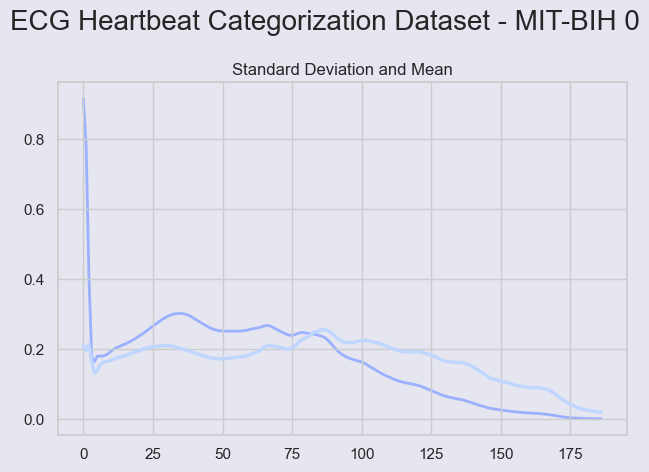

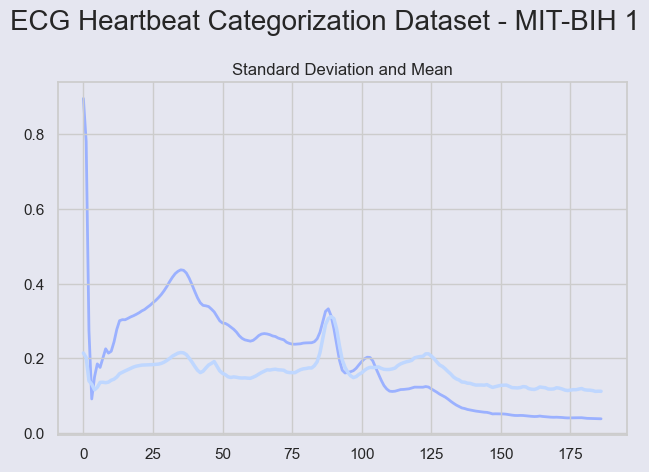

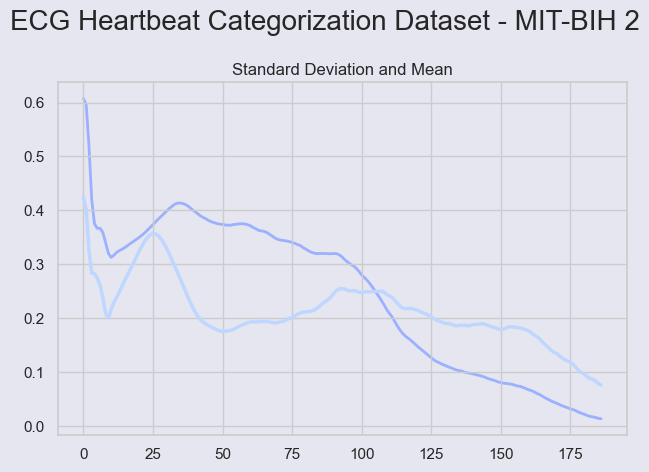

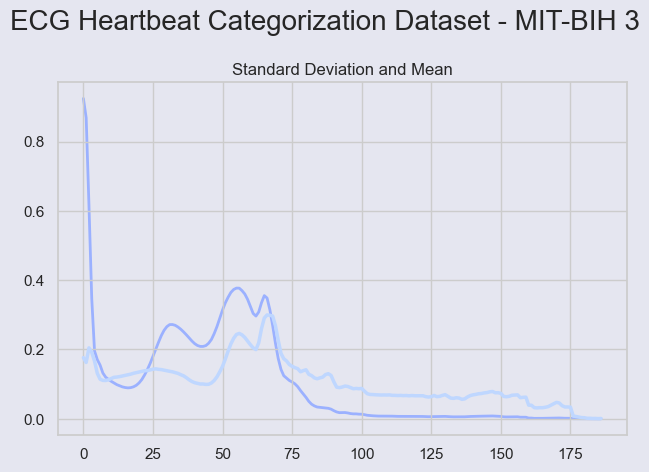

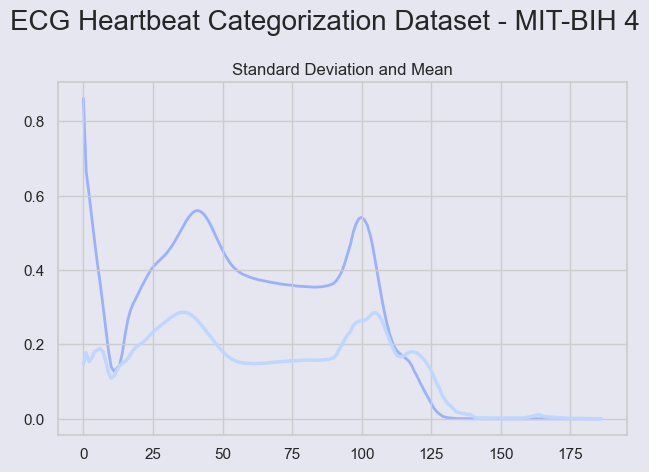

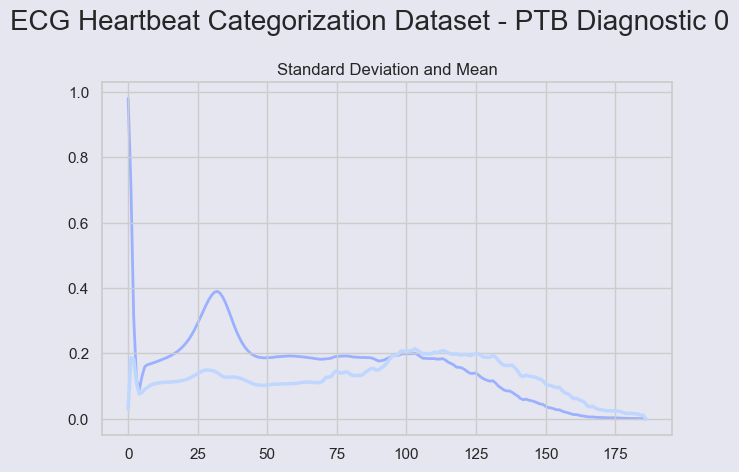

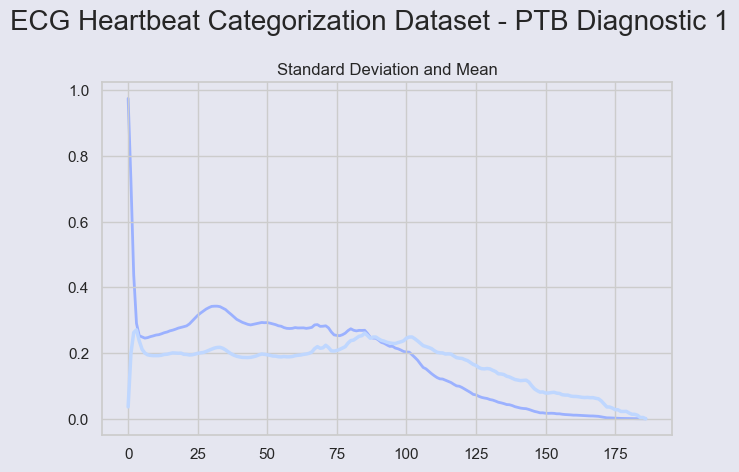

In [67]:
results_dir = '3.1/2/3'

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

X_mitbih = pd.concat([X_train_mitbih, X_test_mitbih]).to_numpy()
y_mitbih = pd.concat([y_train_mitbih, y_test_mitbih]).to_numpy()


for label in labels_mitbih:
    indexes = [i for i in range(y_mitbih.shape[0]) if y_mitbih[i] == label]

    std_mitbih = np.std(X_mitbih[indexes], axis=0)
    mean_mitbih = np.mean(X_mitbih[indexes], axis=0)

    fig = plt.figure(facecolor=bg_color)
    fig.suptitle('ECG Heartbeat Categorization Dataset - MIT-BIH ' + str(label) , fontsize=20)
    ax = fig.add_subplot(1, 1, 1, facecolor=bg_color)
    ax.set_title('Standard Deviation and Mean')
    ax.plot(time_sample, std_mitbih, color=colors[3], linewidth=2.5)
    ax.plot(time_sample, mean_mitbih, color=colors[2], linewidth=2, zorder=-1)

    plt.savefig(results_dir + 'ECG_Heartbeat_Categorization_Dataset_MIT_BIH_mean_std_' + str(label) + '.png')
    plt.show()


for label in labels_ptbdb:
    indexes = [i for i in range(y_ptbdb.shape[0]) if y_ptbdb.to_numpy()[i] == label]
    std_ptbdb = np.std(X_ptbdb.to_numpy()[indexes], axis=0)
    mean_ptbdb = np.mean(X_ptbdb.to_numpy()[indexes], axis=0)

    fig = plt.figure(facecolor=bg_color)
    fig.suptitle('ECG Heartbeat Categorization Dataset - PTB Diagnostic ' + str(label) , fontsize=20)
    ax = fig.add_subplot(1, 1, 1, facecolor=bg_color)
    ax.set_title('Standard Deviation and Mean')
    ax.plot(time_sample, std_ptbdb, color=colors[3], linewidth=2.5)
    ax.plot(time_sample, mean_ptbdb, color=colors[2], linewidth=2, zorder=-1)
    plt.savefig(results_dir + 'ECG_Heartbeat_Categorization_Dataset_PTB_Diagnostic_mean_std_' + str(label) + '.png')

    plt.show()

4) Pentru setul de date RacketSports afișați distribuția valorilor per fiecare axă de
accelerometru și giroscop în parte / per acțiune (a se vedea un exemplu fictiv de
output în Figura 1). O astfel de analiză este utilă pentru a determina dacă există niște
șabloane imediate care se pot observa în termen de valori specifice pe x, y și z
pentru fiecare gest în parte. Aceste șabloane (e.g. intervale de valori specifice) pot fi
folosite în etapa de definire a atributelor și pot totodată informa dacă problema este
una ușoară (șabloane de valori clar diferențiabile per gest) sau grea (distribuții
similare per fiecare gest).


In [ ]:
shutil.rmtree('ECG', ignore_errors=True)
shutil.rmtree('RacketSports', ignore_errors=True)